# Model building

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
finalData = pd.read_csv("finalData.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.5.0


In [4]:
finalDataLog = finalData.copy()

finalDataLog['log_salePrice_b']=np.log(finalDataLog['salePrice_b'])

X = finalDataLog.drop(['salePrice_b', 'log_salePrice_b', 'paymentCash_b',  'AVM_pris_d'], axis = 1)
y = finalDataLog['log_salePrice_b']


X, y = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)


In [5]:
X_area_train = np.array(X_train['areaWeighted_bd'])

In [6]:
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(X_area_train)

In [7]:
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(units=1)
])

area_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [8]:
area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [9]:
%%time
history1 = area_model.fit(
    X_train['areaWeighted_bd'], y_train,
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 5s, sys: 7.14 s, total: 1min 12s
Wall time: 49.2 s


In [10]:
hist = pd.DataFrame(history1.history)
hist['epoch'] = history1.epoch
hist.tail()

,loss,val_loss,epoch
195,0.228076,0.229733,195
196,0.228662,0.246010,196
197,0.226443,0.227923,197
198,0.227689,0.236804,198
199,0.228991,0.233997,199


In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('MAE [logPrice]')
  plt.legend()
  plt.grid(True)

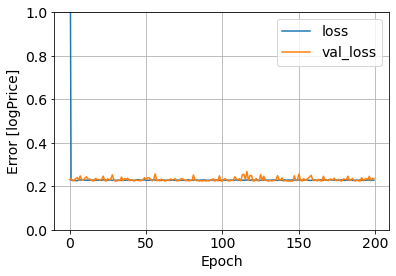

In [12]:
plt.rcParams.update({'font.size': 14})
plot_loss(history1)

In [13]:
x_model1 = tf.linspace(0.0, 500, 100)
y_model1 = area_model.predict(x_model1)

In [14]:
def plot_area(x, y):
  plt.scatter(X_train['areaWeighted_bd'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Area weighted')
  plt.ylabel('Log-price')
  plt.legend()

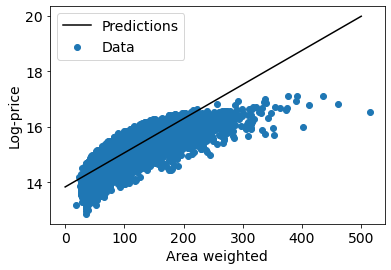

In [16]:
plot_area(x_model1,y_model1)

In [17]:
test_results = {}

test_results['area_model'] = area_model.evaluate(
    X_test['areaWeighted_bd'],
    y_test, verbose=0)

In [18]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [19]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 92)                185       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 93        
Total params: 278
Trainable params: 93
Non-trainable params: 185
_________________________________________________________________


In [20]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [21]:
%%time
history2 = linear_model.fit(
    X_train, y_train, 
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 33s, sys: 12.8 s, total: 1min 46s
Wall time: 1min 10s


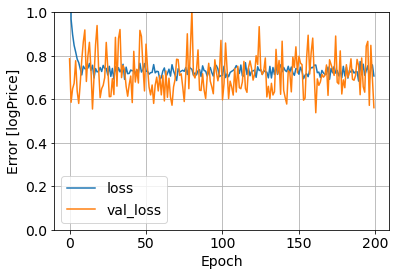

In [22]:
plot_loss(history2)

In [24]:
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

In [25]:
test_results

{'area_model': 0.2275732010602951, 'linear_model': 0.5646715760231018}

In [26]:
hist = pd.DataFrame(history2.history)
hist['epoch'] = history2.epoch
hist.tail()

,loss,val_loss,epoch
195,0.754414,0.866830,195
196,0.695623,0.572228,196
197,0.742742,0.848290,197
198,0.758490,0.698585,198
199,0.707283,0.561649,199


In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#https://keras.io/api/optimizers/adam/

In [28]:
dnn_area_model = build_and_compile_model(area_normalizer)
dnn_area_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [29]:
%%time
history3 = dnn_area_model.fit(
    X_train['areaWeighted_bd'], y_train,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 1min 39s, sys: 17.6 s, total: 1min 57s
Wall time: 1min 8s


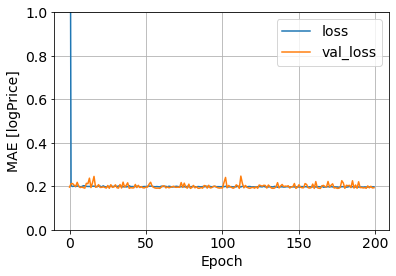

In [30]:
plot_loss(history3)

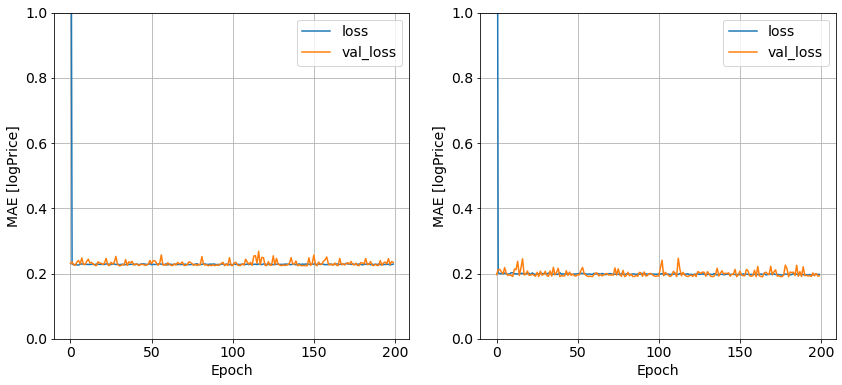

In [31]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(1,2,1)

plot_loss(history1)

ax = plt.subplot(1,2,2)

plot_loss(history3)

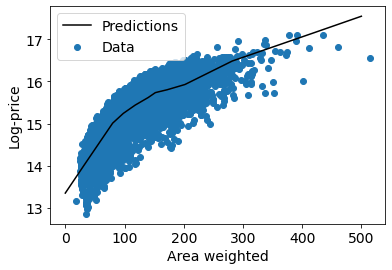

In [32]:
x_model2 = tf.linspace(0.0, 500, 251)
y_model2 = dnn_area_model.predict(x_model2)
plot_area(x_model2, y_model2)

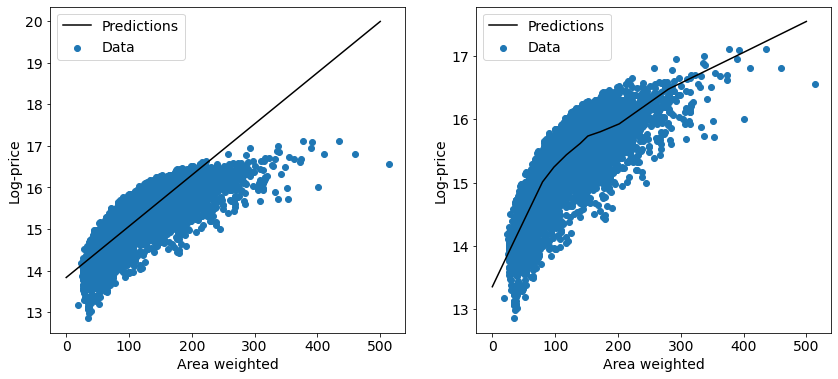

In [33]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(1,2,1)

plot_area(x_model1, y_model1)

ax = plt.subplot(1,2,2)

plot_area(x_model2, y_model2)

In [34]:
test_results['dnn_area_model'] = dnn_area_model.evaluate(
    X_test['areaWeighted_bd'], y_test,
    verbose=0)

In [140]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 92)                185       
_________________________________________________________________
dense_23 (Dense)             (None, 64)                5952      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 10,362
Trainable params: 10,177
Non-trainable params: 185
_________________________________________________________________


In [141]:
%%time
history4 = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=400)

CPU times: user 3min 40s, sys: 37.5 s, total: 4min 17s
Wall time: 2min 27s


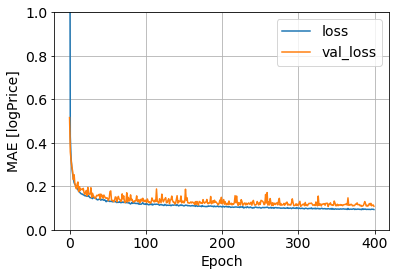

In [142]:
plot_loss(history4)

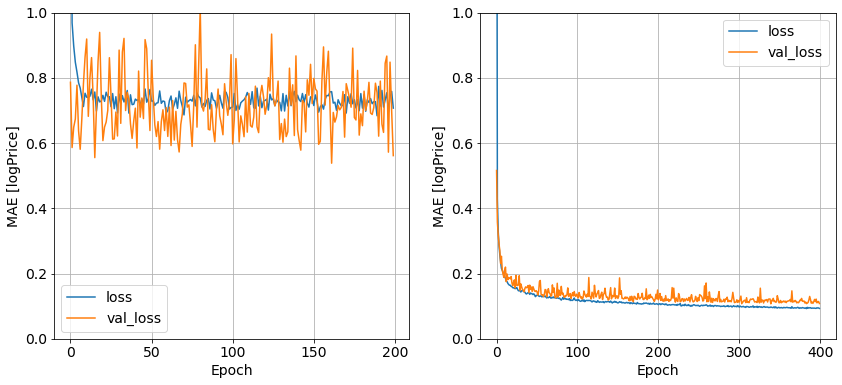

In [143]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(1,2,1)

plot_loss(history2)

ax = plt.subplot(1,2,2)

plot_loss(history4)

In [144]:
hist = pd.DataFrame(history4.history)
hist['epoch'] = history4.epoch
hist.tail()

,loss,val_loss,epoch
395,0.093413,0.121774,395
396,0.095075,0.110298,396
397,0.094361,0.112974,397
398,0.094703,0.114398,398
399,0.093193,0.108161,399


In [145]:
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [146]:
pd.DataFrame(test_results, index=['Mean absolute error [logPrice]']).T

,Mean absolute error [logPrice]
area_model,0.227573
linear_model,0.564672
dnn_area_model,0.191562
dnn_model,0.103964


In [147]:
y_train_pred = dnn_model.predict(X_train).flatten()
y_test_pred = dnn_model.predict(X_test).flatten()

(12.5, 18.5)

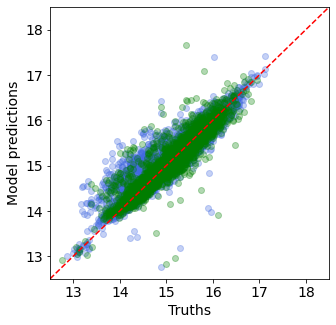

In [148]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_train, y_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(y_test, y_test_pred, alpha=0.3, c = 'green')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([12.5, 18.5])
plt.ylim([12.5, 18.5])

# We can see we have captured the non-linearity, since no longer this curved shape

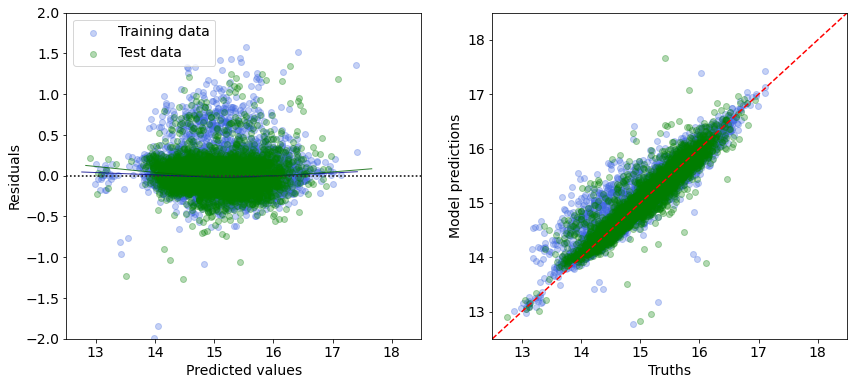

In [149]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(1,2,1)

sns.residplot(x=y_train_pred, y=y_train_pred - y_train, lowess=True, color = 'royalblue', 
                              scatter_kws={'alpha': 0.3}, 
                              line_kws={'color': 'darkblue', 'lw': 1, 'alpha': 0.8}, label='Training data')
sns.residplot(x=y_test_pred, y=y_test_pred - y_test, color = 'green', 
                              scatter_kws={'alpha': 0.3}, lowess=True,
                              line_kws={'color': 'darkgreen', 'lw': 1, 'alpha': 0.8}, label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.xlim([12.5, 18.5])
plt.ylim([-2, 2])

ax = plt.subplot(1,2,2)


plt.scatter(y_train, y_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(y_test, y_test_pred, alpha=0.3, c = 'green')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([12.5, 18.5])
plt.ylim([12.5, 18.5])

plt.show()

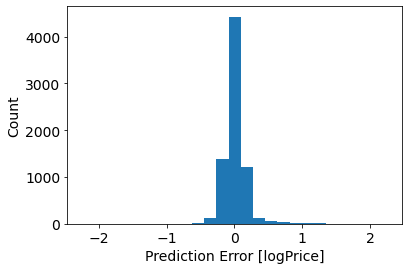

In [150]:
error = y_test_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [logPrice]')
_ = plt.ylabel('Count')

In [151]:
#dnn_model.save('dnn_model')

In [152]:
#reloaded = tf.keras.models.load_model('dnn_model')

#test_results['reloaded'] = reloaded.evaluate(
#    X_test, y_test, verbose=0)

In [153]:
pd.DataFrame(test_results, index=['Mean absolute error [logPrice]']).T

,Mean absolute error [logPrice]
area_model,0.227573
linear_model,0.564672
dnn_area_model,0.191562
dnn_model,0.103964


In [154]:
results3 = pd.DataFrame({'MSE, train' : [(mean_squared_error(y_train, y_train_pred))],
                        'MAE, train' : (mean_absolute_error(y_train, y_train_pred)),
                        'R^2, train' : (r2_score(y_train, y_train_pred)),
                        'MSE, test' : (mean_squared_error(y_test, y_test_pred)),
                        'MAE, test' : (mean_absolute_error(y_test, y_test_pred)),
                        'R^2, test' : (r2_score(y_test, y_test_pred))},
                        index = ['NN'])

print(results3.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MAE, train &  R\textasciicircum 2, train &  MSE, test &  MAE, test &  R\textasciicircum 2, test \\
\midrule
NN &    0.020428 &    0.088891 &    0.920101 &   0.027891 &   0.103964 &   0.889642 \\
\bottomrule
\end{tabular}



In [155]:
mean_percent = np.mean(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100

median_percent = np.median(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100


def within15(y_pred, y_test):
    dataset = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test}, columns=['y_pred', 'y_test'])
    dataset['exp_y_pred'] = np.exp(dataset.y_pred)
    dataset['exp_y_test'] = np.exp(dataset.y_test)
    dataset['difference'] = abs(dataset.exp_y_test-dataset.exp_y_pred)
    dataset['diffpercent'] = dataset.difference / dataset.exp_y_test *100
    return (len(dataset[dataset.diffpercent < 15]) / len(dataset)) *100

dev3 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 15 %': [within15(y_test_pred, y_test)]},
                        index = ['NN'])

print(dev3.round(2).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 15 \% \\
\midrule
NN &             11.08 &                7.16 &        80.73 \\
\bottomrule
\end{tabular}



In [ ]:
#Including asking price

In [156]:
finalDataLog = finalData.copy()

finalDataLog['log_salePrice_b']=np.log(finalDataLog['salePrice_b'])

X = finalDataLog.drop(['salePrice_b', 'log_salePrice_b',  'AVM_pris_d'], axis = 1)
y = finalDataLog['log_salePrice_b']


X, y = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [157]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [158]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 93)                187       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                6016      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 10,428
Trainable params: 10,241
Non-trainable params: 187
_________________________________________________________________


In [159]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=400)

CPU times: user 3min 43s, sys: 38.4 s, total: 4min 22s
Wall time: 2min 33s


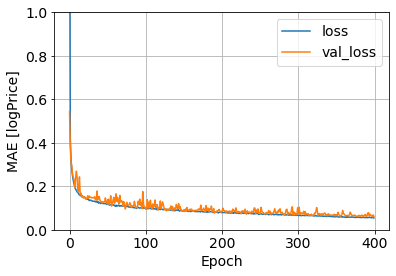

In [160]:
plot_loss(history)

In [161]:
y_train_pred = dnn_model.predict(X_train).flatten()
y_test_pred = dnn_model.predict(X_test).flatten()

(12.5, 18.5)

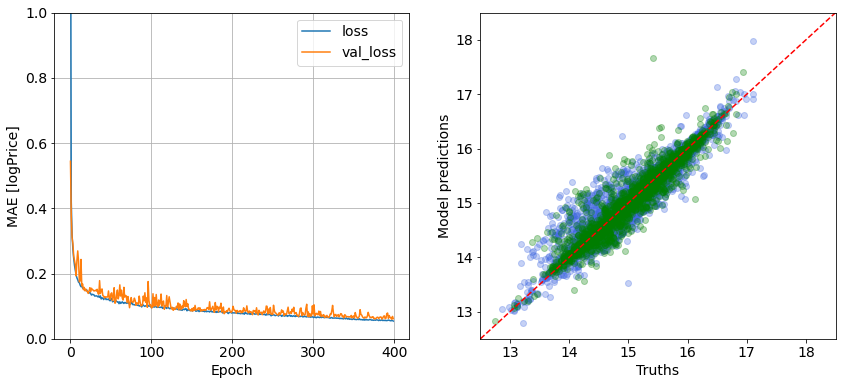

In [162]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(1,2,1)

plot_loss(history)

ax = plt.subplot(1,2,2)

plt.scatter(y_train, y_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(y_test, y_test_pred, alpha=0.3, c = 'green')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([12.5, 18.5])
plt.ylim([12.5, 18.5])

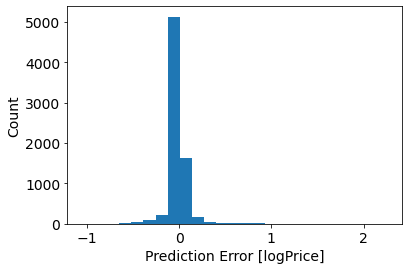

In [163]:
error = y_test_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [logPrice]')
_ = plt.ylabel('Count')

In [164]:
results5 = pd.DataFrame({'MSE, train' : [(mean_squared_error(y_train, y_train_pred))],
                        'MAE, train' : (mean_absolute_error(y_train, y_train_pred)),
                        'R^2, train' : (r2_score(y_train, y_train_pred)),
                        'MSE, test' : (mean_squared_error(y_test, y_test_pred)),
                        'MAE, test' : (mean_absolute_error(y_test, y_test_pred)),
                        'R^2, test' : (r2_score(y_test, y_test_pred))},
                        index = ['NN Cash'])

print(results5.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MAE, train &  R\textasciicircum 2, train &  MSE, test &  MAE, test &  R\textasciicircum 2, test \\
\midrule
NN Cash &    0.011854 &    0.053992 &    0.953636 &   0.014259 &   0.060499 &    0.94358 \\
\bottomrule
\end{tabular}



In [165]:
mean_percent = np.mean(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100

median_percent = np.median(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100


def within15(y_pred, y_test):
    dataset = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test}, columns=['y_pred', 'y_test'])
    dataset['exp_y_pred'] = np.exp(dataset.y_pred)
    dataset['exp_y_test'] = np.exp(dataset.y_test)
    dataset['difference'] = abs(dataset.exp_y_test-dataset.exp_y_pred)
    dataset['diffpercent'] = dataset.difference / dataset.exp_y_test *100
    return (len(dataset[dataset.diffpercent < 15]) / len(dataset)) *100

dev5 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 15 %': [within15(y_test_pred, y_test)]},
                        index = ['NN Cash'])

print(dev5.round(2).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 15 \% \\
\midrule
NN Cash &              6.35 &                3.23 &        92.12 \\
\bottomrule
\end{tabular}



In [167]:
# To results
#results3.to_csv('results3.csv', index=True)
#results5.to_csv('results5.csv', index=True)
#dev3.to_csv('dev3.csv', index=True)
#dev5.to_csv('dev5.csv', index=True)

In [168]:
# Corona split

finalDataLog_corona = shuffle(finalDataLog, random_state=0)

finalDataLog_2020 = finalDataLog_corona.loc[finalDataLog['salesYear_b'] == 2020,]
finalDataLog_x = finalDataLog_corona.loc[~(finalDataLog['salesYear_b'] == 2020),]


X_train = finalDataLog_x.drop(['salePrice_b', 'log_salePrice_b', 'paymentCash_b',  'AVM_pris_d'], axis = 1)
y_train = finalDataLog_x['log_salePrice_b']
X_test = finalDataLog_2020.drop(['salePrice_b', 'log_salePrice_b', 'paymentCash_b',  'AVM_pris_d'], axis = 1)
y_test = finalDataLog_2020['log_salePrice_b']


In [169]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 92)                185       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                5952      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 10,362
Trainable params: 10,177
Non-trainable params: 185
_________________________________________________________________


In [170]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=400)

CPU times: user 3min 43s, sys: 38.7 s, total: 4min 22s
Wall time: 2min 32s


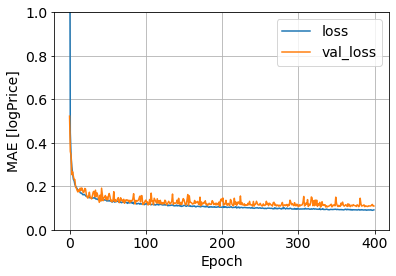

In [171]:
plot_loss(history)

In [172]:
y_train_pred = dnn_model.predict(X_train).flatten()
y_test_pred = dnn_model.predict(X_test).flatten()

(12.5, 18.5)

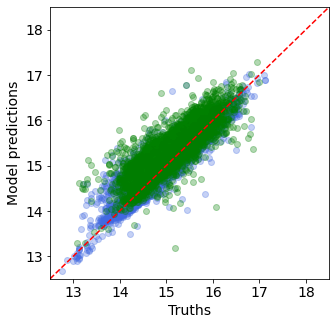

In [173]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_train, y_train_pred, alpha=0.3, c = 'royalblue')
plt.scatter(y_test, y_test_pred, alpha=0.3, c = 'green')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([12.5, 18.5])
plt.ylim([12.5, 18.5])

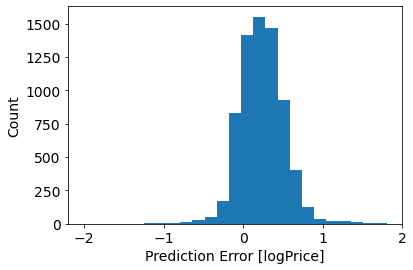

In [174]:
error = y_test_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [logPrice]')
_ = plt.ylabel('Count')

In [175]:
results9 = pd.DataFrame({'MSE, train' : [(mean_squared_error(y_train, y_train_pred))],
                        'MAE, train' : (mean_absolute_error(y_train, y_train_pred)),
                        'R^2, train' : (r2_score(y_train, y_train_pred)),
                        'MSE, test' : (mean_squared_error(y_test, y_test_pred)),
                        'MAE, test' : (mean_absolute_error(y_test, y_test_pred)),
                        'R^2, test' : (r2_score(y_test, y_test_pred))},
                        index = ['NN Corona'])

print(results9.to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  MSE, train &  MAE, train &  R\textasciicircum 2, train &  MSE, test &  MAE, test &  R\textasciicircum 2, test \\
\midrule
NN Corona &    0.018617 &    0.090398 &    0.926827 &   0.133425 &   0.286586 &    0.46961 \\
\bottomrule
\end{tabular}



In [176]:
mean_percent = np.mean(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100

median_percent = np.median(abs(np.exp(y_test)-np.exp(y_test_pred))/np.exp(y_test))*100


def within15(y_pred, y_test):
    dataset = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test}, columns=['y_pred', 'y_test'])
    dataset['exp_y_pred'] = np.exp(dataset.y_pred)
    dataset['exp_y_test'] = np.exp(dataset.y_test)
    dataset['difference'] = abs(dataset.exp_y_test-dataset.exp_y_pred)
    dataset['diffpercent'] = dataset.difference / dataset.exp_y_test *100
    return (len(dataset[dataset.diffpercent < 15]) / len(dataset)) *100

dev9 = pd.DataFrame({'Mean deviation %' : [mean_percent],
                    'Median deviation %' : [median_percent],
                    'Within 15 %': [within15(y_test_pred, y_test)]},
                        index = ['NN Corona'])

print(dev9.round(2).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  Mean deviation \% &  Median deviation \% &  Within 15 \% \\
\midrule
NN Corona &             36.18 &               27.22 &        33.11 \\
\bottomrule
\end{tabular}



In [177]:

#results9.to_csv('results9.csv', index=True)

#dev9.to_csv('dev9.csv', index=True)


In [179]:
y_train_pred_C = dnn_model.predict(X_train).flatten()
y_test_pred_C = dnn_model.predict(X_test).flatten()


In [186]:
corona_train = pd.DataFrame({'y_train_C': y_train,'y_train_pred_C': y_train_pred_C}, columns=['y_train_C','y_train_pred_C'])

In [187]:
corona_test = pd.DataFrame({'y_test_C': y_test,'y_test_pred_C': y_test_pred_C}, columns=['y_test_C','y_test_pred_C'])

In [188]:

#y_train_pred_C.to_csv('y_train_pred_C.csv', index=True)
#y_test_pred_C.to_csv('y_test_pred_C.csv', index=True)
#corona_train.to_csv('corona_train.csv', index=True)
#corona_test.to_csv('corona_test.csv', index=True)